In [1]:
from neuralprophet import NeuralProphet, set_log_level
import pandas as pd
import matplotlib.pyplot as plt

set_log_level("ERROR")

c:\Users\ASUS TUF\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.


In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, root_mean_squared_error
from keras.optimizers import Adam

In [3]:
# Get data
ds1 = pd.read_csv('../BBCA.JK.csv')
ds2 = pd.read_csv('../BBRI.JK.csv')
ds3 = pd.read_csv('../BMRI.JK.csv')

ds = ds1
ds.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-05-31,5740.0,5870.0,5735.0,5820.0,5229.245117,96875000
1,2019-06-03,5820.0,5820.0,5820.0,5820.0,5229.245117,0
2,2019-06-04,5820.0,5820.0,5820.0,5820.0,5229.245117,0
3,2019-06-05,5820.0,5820.0,5820.0,5820.0,5229.245117,0
4,2019-06-06,5820.0,5820.0,5820.0,5820.0,5229.245117,0


In [4]:
print(ds1['Date'].min())
print(ds1['Date'].max())
print(ds2['Date'].min())
print(ds2['Date'].max())
print(ds3['Date'].min())
print(ds3['Date'].max())

2019-05-31
2024-05-30
2019-05-31
2024-05-30
2019-05-31
2024-05-30


EDA

In [5]:
# Check for missing values from the datasets
print(len(ds))
print(len(ds2))
print(len(ds3))

print(ds.isnull().sum())
print(ds2.isnull().sum())
print(ds3.isnull().sum())

1215
1215
1215
Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64
Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64
Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


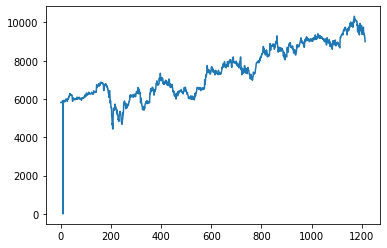

In [6]:
plt.plot(ds.Close)

In [7]:
# Check for missing value
print(ds.isnull().sum())
print(len(ds))

# Handle missing value if there's any with forward fill
ds.fillna(value='ffil', inplace=True)
print(ds.isnull().sum())

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64
1215
Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


In [8]:
# Take date and close as dataset
ds = ds[['Date', 'Close']]
ds

,Date,Close
0,2019-05-31,5820.0
1,2019-06-03,5820.0
2,2019-06-04,5820.0
3,2019-06-05,5820.0
4,2019-06-06,5820.0
...,...,...
1210,2024-05-22,9425.0
1211,2024-05-27,9300.0
1212,2024-05-28,9300.0
1213,2024-05-29,9150.0


In [9]:
print(ds['Close'].min())
print(ds['Close'].max())

0.0
10325.0


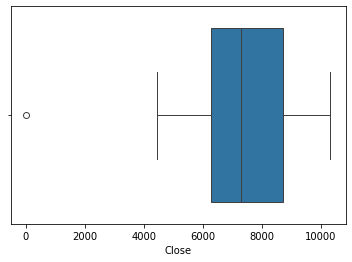

In [10]:
# Box plot to check for outliers
import seaborn as sns

sns.boxplot(x=ds['Close'])
plt.show()

# Proposed Ensemble NP-Trans

In [11]:
# Set dataset for neuralprophet by renaming the columns
ds_np = ds.rename(columns={'Date': 'ds', 'Close': 'y'})
ds_np

,ds,y
0,2019-05-31,5820.0
1,2019-06-03,5820.0
2,2019-06-04,5820.0
3,2019-06-05,5820.0
4,2019-06-06,5820.0
...,...,...
1210,2024-05-22,9425.0
1211,2024-05-27,9300.0
1212,2024-05-28,9300.0
1213,2024-05-29,9150.0


In [12]:
# # change data split size:
# test_size = -30
# valid_size = -495

# ds_np_train, ds_np_val, ds_np_test = ds_np[:valid_size], ds_np[valid_size:test_size], ds_np[test_size:]
# train_len = len(ds_np_train)
# val_len = len(ds_np_val)
# total_train = train_len + val_len
# print(len(ds_np_train))
# print(len(ds_np_val))
# print(len(ds_np_test))

In [13]:
# Data split with ratio
test_ratio = 0.1
valid_ratio = 0.4

# Calculate size of split based on ratio
test_size = -1 * round(test_ratio * len(ds_np))
valid_size = -1 * round((valid_ratio + test_ratio) * len(ds_np))

print(test_size)
print(valid_size)

# Split the dataset into training, validation, and test sets
ds_np_train, ds_np_val, ds_np_test = ds_np[:valid_size], ds_np[valid_size:test_size], ds_np[test_size:]

train_len = len(ds_np_train)
val_len = len(ds_np_val)
total_train = train_len + val_len

# Print lengths to verify
print(len(ds_np_train), len(ds_np_val), len(ds_np_test))

-122
-608
607 486 122


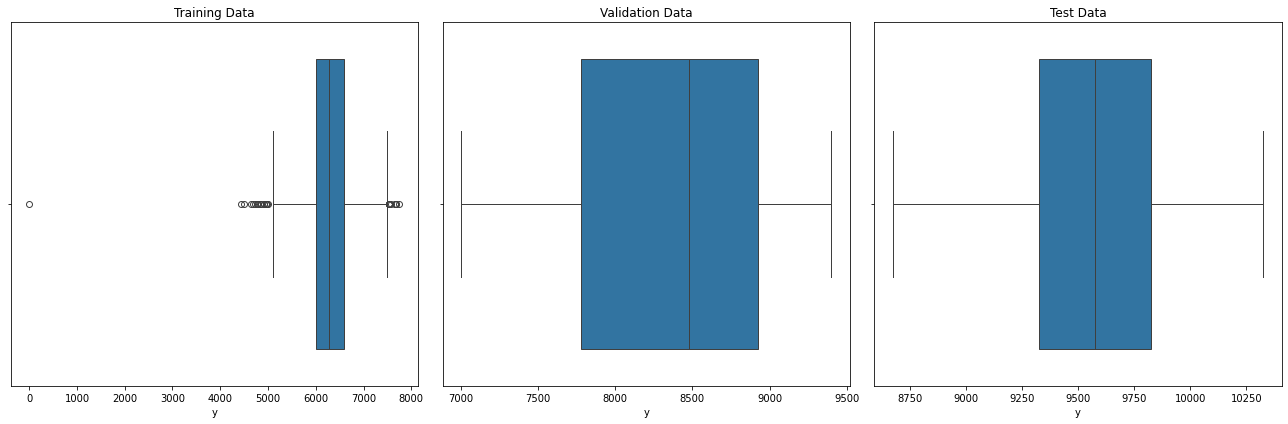

In [14]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# training data box plot
sns.boxplot(ax=axes[0], x=ds_np_train['y'])
axes[0].set_title('Training Data')

# validation data box plot
sns.boxplot(ax=axes[1], x=ds_np_val['y'])
axes[1].set_title('Validation Data')

# test data box plot
sns.boxplot(ax=axes[2], x=ds_np_test['y'])
axes[2].set_title('Test Data')

# # Set a common y-label
# fig.text(0, 0.5, 'Value', va='center', rotation='vertical')

plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Test Data')

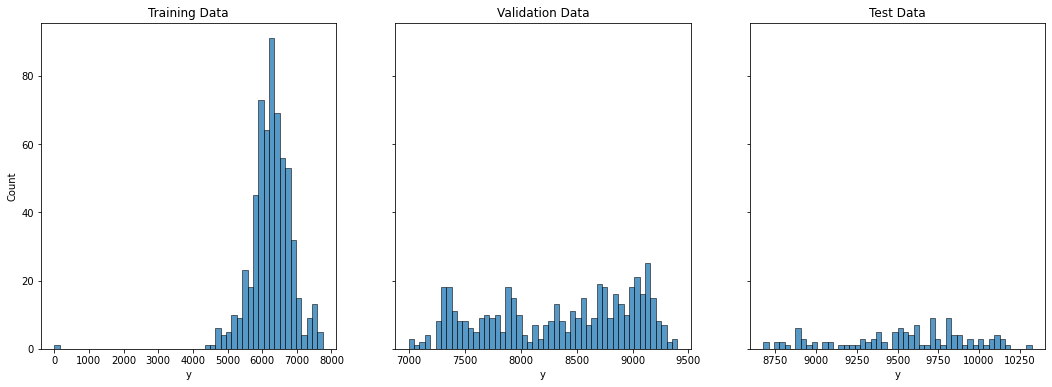

In [15]:
# Plot histograms for each split
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

sns.histplot(ds_np_train['y'], ax=axes[0], bins=50)
axes[0].set_title('Training Data')

sns.histplot(ds_np_val['y'], ax=axes[1], bins=50)
axes[1].set_title('Validation Data')

sns.histplot(ds_np_test['y'], ax=axes[2], bins=50)
axes[2].set_title('Test Data')

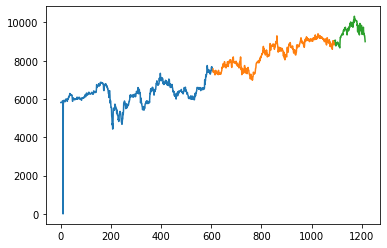

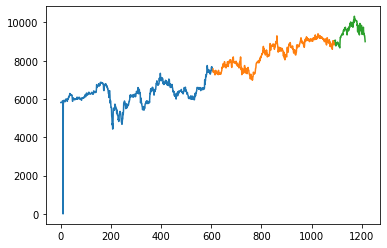

In [16]:
# plt.subplot(1, 2, 1)
plt.plot(ds.Close[:valid_size])
plt.plot(ds.Close[valid_size:test_size])
plt.plot(ds.Close[test_size:])
plt.show()

# plt.subplot(1, 2, 2)
plt.plot(ds_np_train.y)
plt.plot(ds_np_val.y)
plt.plot(ds_np_test.y)

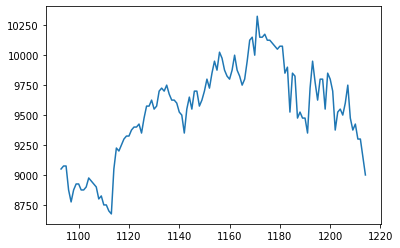

variance: 157184.36695569707
standar deviation: 396.4648369725833
mean: 9540.368852459016
cv: 0.04155655227841585


In [17]:
# Check variance of the dataset (is this the reason of the bad R2)
plt.plot(ds.Close[test_size:])
plt.show()

# plt.plot(ds_np_test.y)

variance = ds.Close[test_size:].var()
std = ds.Close[test_size:].std()
mean = ds.Close[test_size:].mean()
print(f'variance: {variance}')
print(f'standar deviation: {std}')
print(f'mean: {mean}')
print(f'cv: {std/mean}')

## NeuralProphet

Finding best initial lr: 100%|██████████| 221/221 [00:00<00:00, 230.16it/s]


Epoch 130: 100%|██████████| 130/130 [00:00<00:00, 1339.91it/s, loss=0.00119, v_num=306, MAE_val=77.40, RMSE_val=101.0, Loss_val=0.000335, RegLoss_val=0.000, MAE=85.50, RMSE=180.0, Loss=0.00115, RegLoss=0.000]  


,MAE_val,RMSE_val,Loss_val,RegLoss_val,epoch,MAE,RMSE,Loss,RegLoss
0,2798.895508,3687.348633,0.267655,0.0,0,3012.130859,3971.373047,0.219123,0.0
1,2350.697021,3115.223389,0.211171,0.0,1,2520.947021,3351.311035,0.172750,0.0
2,1914.412354,2545.898926,0.157105,0.0,2,2100.906738,2847.137939,0.134940,0.0
3,1498.217407,1991.789795,0.107441,0.0,3,1693.738037,2329.718262,0.099421,0.0
4,1110.091187,1452.030518,0.063182,0.0,4,1252.810303,1743.273682,0.064573,0.0
...,...,...,...,...,...,...,...,...,...
125,77.494095,101.048164,0.000336,0.0,125,87.633385,181.777374,0.001157,0.0
126,77.483833,101.046608,0.000336,0.0,126,91.426559,185.027039,0.001183,0.0
127,77.421898,100.952774,0.000335,0.0,127,83.947159,179.288315,0.001150,0.0
128,77.407982,100.933769,0.000335,0.0,128,84.475723,178.594818,0.001150,0.0


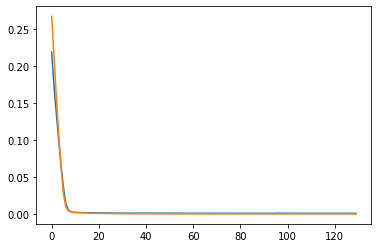

In [18]:
# Set NP model
n_lags = 2

np_model = NeuralProphet(
    n_changepoints=2,
    n_lags=n_lags,
    drop_missing=True,
)

# Train NP 
metrics = np_model.fit(ds_np_train, validation_df=ds_np_val, progress="plot")
metrics

In [19]:
# Generate prediction with val data (used to train meta model)
forecast = np_model.predict(ds_np_val)
# forecast

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 499.86it/s]


In [20]:
metrics_test = np_model.test(ds_np_val)

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 124.98it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         Loss_test         │  0.00033525703474879265   │
│          MAE_val          │     77.4495620727539      │
│         RMSE_val          │    100.98213958740234     │
│       RegLoss_test        │            0.0            │
└───────────────────────────┴───────────────────────────┘

In [21]:
np_model.plot(forecast)

ERROR - (NP.plotly.plot) - plotly-resampler is not installed. Please install it to use the resampler.


In [22]:
np_model.plot_components(forecast)

ERROR - (NP.plotly.plot_components) - plotly-resampler is not installed. Please install it to use the resampler.


In [23]:
forecast

,ds,y,yhat1,ar1,trend,season_yearly,season_weekly
0,2021-11-17,7575.0,NaN,NaN,NaN,NaN,NaN
1,2021-11-18,7400.0,NaN,NaN,NaN,NaN,NaN
2,2021-11-19,7425.0,7441.857910,-1381.169800,8513.840820,471.555054,-162.368713
3,2021-11-22,7475.0,7461.346680,-1396.509521,8513.403320,508.742279,-164.288910
4,2021-11-23,7475.0,7488.950195,-1380.887329,8513.256836,522.491150,-165.911011
...,...,...,...,...,...,...,...
515,2023-11-08,9000.0,9003.132812,388.693390,8408.816406,361.749023,-156.126389
516,2023-11-09,9000.0,8999.208984,382.585876,8408.670898,370.789429,-162.837189
517,2023-11-10,8825.0,9009.476562,382.497162,8408.524414,379.718536,-161.263733
518,2023-11-13,8875.0,8879.401367,228.033295,8408.085938,406.396667,-163.114731


In [24]:
print(f"MAE: {mean_absolute_error(forecast['y'][n_lags:], forecast['yhat1'][n_lags:])}")
print(f"RMSE: {root_mean_squared_error(forecast['y'][n_lags:], forecast['yhat1'][n_lags:])}")
print(f"R2: {r2_score(forecast['y'][n_lags:], forecast['yhat1'][n_lags:])}")

MAE: 77.44957789122829
RMSE: 100.98214937051637
R2: 0.9760338435059907


In [25]:
# Check test data (not used)

# forecast_test = np_model.predict(ds_np_test)
# metrics_test2 = np_model.test(ds_np_test)

# np_model.plot(forecast_test)

# np_model.plot_components(forecast_test)

# print(f"MAE: {mean_absolute_error(forecast_test['y'][n_lags:], forecast_test['yhat1'][n_lags:])}")
# print(f"RMSE: {root_mean_squared_error(forecast_test['y'][n_lags:], forecast_test['yhat1'][n_lags:])}")
# print(f"R2: {r2_score(forecast_test['y'][n_lags:], forecast_test['yhat1'][n_lags:])}")

## Transformer

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, root_mean_squared_error
import tensorflow as tf
from keras import layers
# from keras.layers import MultiHeadAttention, 
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [27]:
# close_prices = ds['Close'].values.reshape(-1,1)
# scler = MinMaxScaler()
# close_prices = scler.fit_transform(close_prices)

In [28]:
# Define window size and number of features
window_size = 10
num_features = 1  # close price

# make input sequences
X = []
y = []
for i in range(len(ds['Close']) - window_size):
    X.append(ds['Close'][i:i+window_size])
    y.append(ds['Close'][i+window_size])

# lists to arrays
X, y = np.array(X), np.array(y)

x_train, x_val, x_test = X[:valid_size], X[valid_size:test_size], X[test_size:]
y_train, y_val, y_test = y[:valid_size], y[valid_size:test_size], y[test_size:]

print(len(x_train), len(x_val), len(x_test))
print(len(y_train), len(y_val), len(y_test))
print(x_train.shape)
print(y_train.shape)

597 486 122
597 486 122
(597, 10)
(597,)


In [29]:
x_train[0]

array([5820., 5820., 5820., 5820., 5820., 5820., 5880., 5910., 5845.,
          0.])

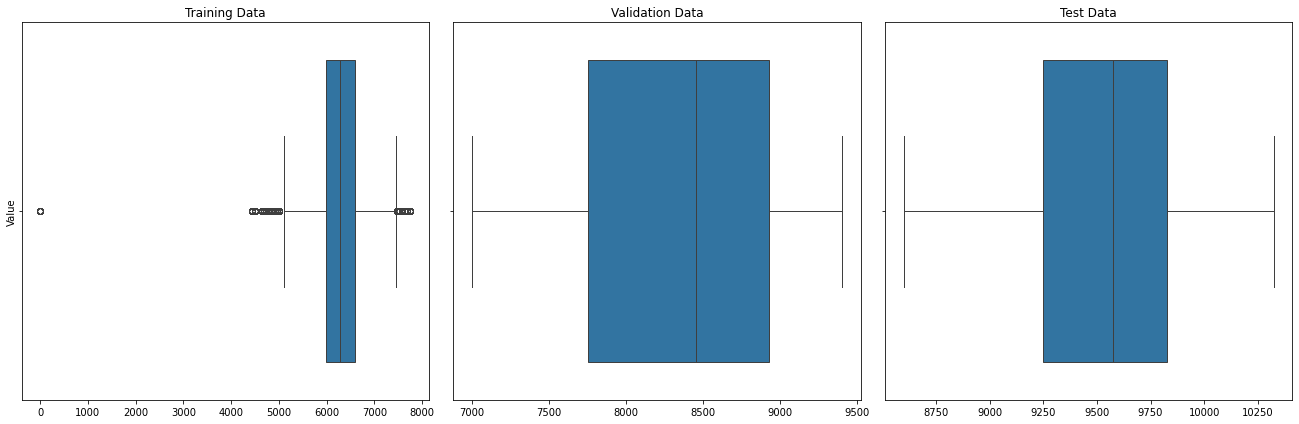

In [30]:
# plt.plot(x_train.flatten(), label='Training Data')
# plt.legend()
# plt.show()

# Outlier detection
# Flatten the data to make it suitable for plotting with boxplot
x_train_flat = x_train.flatten()
x_val_flat = x_val.flatten()
x_test_flat = x_test.flatten()

# Create a figure with subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Create a box plot for the training data
sns.boxplot(ax=axes[0], x=x_train_flat)
axes[0].set_title('Training Data')

# Create a box plot for the validation data
sns.boxplot(ax=axes[1], x=x_val_flat)
axes[1].set_title('Validation Data')

# Create a box plot for the test data
sns.boxplot(ax=axes[2], x=x_test_flat)
axes[2].set_title('Test Data')

# Set a common y-label
fig.text(0, 0.5, 'Value', va='center', rotation='vertical')

plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Test Data')

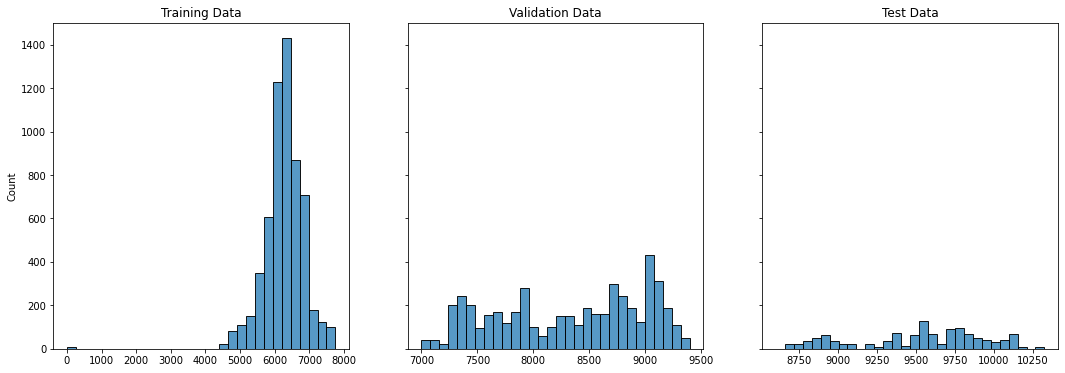

In [31]:
# Plot histograms for each split
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

sns.histplot(x_train_flat, ax=axes[0], bins=30)
axes[0].set_title('Training Data')

sns.histplot(x_val_flat, ax=axes[1], bins=30)
axes[1].set_title('Validation Data')

sns.histplot(x_test_flat, ax=axes[2], bins=30)
axes[2].set_title('Test Data')

In [32]:
# Tried adding normalization to solve the bad R2 score when predicting the test set
# Result: adding normalization result in worse evaluation seen from the MAE, RMSE, and R2

# # Normalize the data using MinMaxScaler
# scaler = MinMaxScaler()
# x_train = scaler.fit_transform(x_train.reshape(-1, 1)).reshape(-1, window_size, num_features)
# x_val = scaler.transform(x_val.reshape(-1, 1)).reshape(-1, window_size, num_features)
# x_test = scaler.transform(x_test.reshape(-1, 1)).reshape(-1, window_size, num_features)


In [33]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim,
                        dropout=0):
  """
  Creates a single transformer block.
  """
  x = layers.LayerNormalization(epsilon=1e-6)(inputs)
  x = layers.MultiHeadAttention(
      key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
  x = layers.Dropout(dropout)(x)
  res = x + inputs

    # Feed Forward Part
  x = layers.LayerNormalization(epsilon=1e-6)(res)
  x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
  x = layers.Dropout(dropout)(x)
  x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
  return x + res

def build_transfromer(head_size, 
                      num_heads,
                      ff_dim,
                      num_trans_blocks,
                      mlp_units, dropout=0, mlp_dropout=0) -> tf.keras.Model:
  """
  Creates final model by building many transformer blocks.
  """
  # n_timesteps, n_features, n_outputs = 5, 1, 5 
  inputs = tf.keras.Input(shape=(window_size, num_features))
  x = inputs 
  for _ in range(num_trans_blocks):
    x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)
  
  x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
  for dim in mlp_units:
    x = layers.Dense(dim, activation="relu")(x)
    x = layers.Dropout(mlp_dropout)(x)

  outputs = layers.Dense(1, activation='linear')(x)
  return tf.keras.Model(inputs, outputs)

# transformer = build_transfromer(head_size=128, num_heads=4, ff_dim=2, num_trans_blocks=4, mlp_units=[256], 
#                                 mlp_dropout=0.10, dropout=0.10)
transformer = build_transfromer(head_size=40, num_heads=60, ff_dim=60, num_trans_blocks=4, mlp_units=[256], 
                                mlp_dropout=0.10, dropout=0.10)

# transformer.compile(loss="mse", optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
#     metrics=["mae", 'mape'],
# )
transformer.compile(loss="mse", optimizer='adam', metrics=["mae", 'mape'])

callbacks = [tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]

In [34]:
class PositionalEncoding(layers.Layer):
    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)

    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'position': self.pos_encoding.shape[0],
            'd_model': self.pos_encoding.shape[1],
        })
        return config

    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(np.arange(position)[:, np.newaxis],
                                     np.arange(d_model)[np.newaxis, :],
                                     d_model)

        # apply sin to even indices in the array; 2i
        angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

        # apply cos to odd indices in the array; 2i+1
        angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

        pos_encoding = angle_rads[np.newaxis, ...]

        return tf.cast(pos_encoding, dtype=tf.float32)

    def get_angles(self, pos, i, d_model):
        angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
        return pos * angle_rates

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

In [35]:
# def transformer_encoder2(inputs, head_size, num_heads, ff_dim,
#                         dropout=0):
#   x = layers.LayerNormalization(epsilon=1e-6)(inputs)
#   x = layers.MultiHeadAttention(
#       key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
#   x = layers.Dropout(dropout)(x)
#   res = x + inputs
  
#   # Feed Forward Part
#   x = layers.LayerNormalization(epsilon=1e-6)(res)
#   x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
#   x = layers.Dropout(dropout)(x)
#   x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
#   return x + res

# def build_transfromer2(head_size, 
#                       num_heads,
#                       ff_dim,
#                       num_trans_blocks,
#                       mlp_units, dropout=0, mlp_dropout=0) -> tf.keras.Model:
#   inputs = tf.keras.Input(shape=(window_size, num_features))
#   x = PositionalEncoding(window_size,num_features)(inputs) 
#   for _ in range(num_trans_blocks):
#     x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)
  
#   x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
#   for dim in mlp_units:
#     x = layers.Dense(dim, activation="relu")(x)
#     x = layers.Dropout(mlp_dropout)(x)

#   outputs = layers.Dense(1, activation='linear')(x)
#   return tf.keras.Model(inputs, outputs)

# transformer2 = build_transfromer2(head_size=128, num_heads=4, ff_dim=2, num_trans_blocks=4, mlp_units=[256], 
#                                 mlp_dropout=0.10, dropout=0.10)

# # transformer.compile(loss="mse", optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
# #     metrics=["mae", 'mape'],
# # )
# transformer2.compile(loss="mse", optimizer='adam', metrics=["mae", 'mape'])

# callbacks = [tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]

In [36]:
histT = transformer.fit(x_train, y_train, batch_size=32, epochs=50,
                         verbose=1, callbacks=callbacks)

Epoch 1/50
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 12428734.0000 - mae: 2983.2441 - mape: 47.5275

WARNING - (py.warnings._showwarnmsg) - c:\Users\ASUS TUF\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\callbacks\early_stopping.py:156: UserWarning:

Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae,mape




19/19 ━━━━━━━━━━━━━━━━━━━━ 9s 54ms/step - loss: 11793696.0000 - mae: 2885.3662 - mape: 45.9687
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 789429.6875 - mae: 712.5683 - mape: 11.3795
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 568043.4375 - mae: 613.7047 - mape: 9.8818
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 449473.5625 - mae: 527.0376 - mape: 8.4536
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 352616.7188 - mae: 479.1574 - mape: 7.7222
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 396140.5938 - mae: 491.8533 - mape: 7.9336
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 385653.7500 - mae: 492.4637 - mape: 7.9240
Epoch 8/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 376225.4688 - mae: 478.6647 - mape: 7.7650
Epoch 9/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 390832.5312 - mae: 490.9177 - mape: 7.8307
Epoch 10/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 334783.1250 - mae: 459.5490 

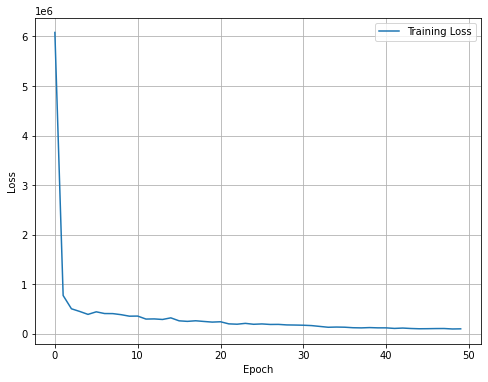

In [37]:
# Graph loss training
plt.figure(figsize=(8, 6))
plt.plot(histT.history['loss'], label='Training Loss')
# plt.plot(histT.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

In [38]:
# histT2 = transformer2.fit(x_train, y_train, batch_size=32, epochs=50,
#                          verbose=1, callbacks=callbacks)

In [39]:
prediction = transformer.predict(x_val)
# prediction2 = transformer2.predict(x_val)

print("TRANSFORMER EVALUATION METRICS")
# mse1 = np.mean((prediction - y_val)**2)
# rmse1 = np.sqrt(mse1)
# mape = np.mean(np.abs((y_val - prediction) / y_val)) * 100

# print('MSE: ', mse1)
# print('RMSE: ', rmse1)
# print('MAPE: ', mape)

print(f"MAE: {mean_absolute_error(prediction, y_val)}")
print(f"RMSE: {root_mean_squared_error(prediction, y_val)}")
print(f"R2: {r2_score(prediction, y_val)}")
# print(f"MSE: {mean_squared_error(prediction, y_val)}")

# print("TRANSFORMER 2 EVALUATION METRICS")
# print(f"MAE: {mean_absolute_error(prediction2, y_val)}")
# print(f"RMSE: {root_mean_squared_error(prediction2, y_val)}")
# print(f"R2: {r2_score(prediction2, y_val)}")
# # print(f"MSE: {mean_squared_error(prediction2, y_val)}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step
TRANSFORMER EVALUATION METRICS
MAE: 100.81081412358539
RMSE: 134.17406072288725
R2: 0.9574062651035898


##### testing stuff

In [40]:
# predTrain = transformer.predict(x_train)

# print(f"MAE: {mean_absolute_error(predTrain, y_train)}")
# print(f"RMSE: {root_mean_squared_error(predTrain, y_train)}")
# print(f"R2: {r2_score(predTrain, y_train)}")
# print(f"R2: {mean_squared_error(predTrain, y_train)}")

In [41]:
# # prediction = scler.inverse_transform(prediction)
# # prediction2 = scler.inverse_transform(prediction2)

# print("TRANSFORMER EVALUATION METRICS")
# # mse1 = np.mean((prediction - y_val)**2)
# # rmse1 = np.sqrt(mse1)
# # mape = np.mean(np.abs((y_val - prediction) / y_val)) * 100

# # print('MSE: ', mse1)
# # print('RMSE: ', rmse1)
# # print('MAPE: ', mape)

# print(f"MAE: {mean_absolute_error(prediction, y_val)}")
# print(f"RMSE: {root_mean_squared_error(prediction, y_val)}")
# print(f"R2: {r2_score(prediction, y_val)}")
# print(f"MSE: {mean_squared_error(prediction, y_val)}")

# print("TRANSFORMER 2 EVALUATION METRICS")
# print(f"MAE: {mean_absolute_error(prediction2, y_val)}")
# print(f"RMSE: {root_mean_squared_error(prediction2, y_val)}")
# print(f"R2: {r2_score(prediction2, y_val)}")
# print(f"MSE: {mean_squared_error(prediction2, y_val)}")

In [42]:
# Check test data (not used)

# testPrd = transformer.predict(x_test)
# testPrd2 = transformer2.predict(x_test)

# print(f"MAE: {mean_absolute_error(testPrd, y_test)}")
# print(f"RMSE: {root_mean_squared_error(testPrd, y_test)}")
# print(f"R2: {r2_score(testPrd, y_test)}")

# print(f"MAE: {mean_absolute_error(testPrd2, y_test)}")
# print(f"RMSE: {root_mean_squared_error(testPrd2, y_test)}")
# print(f"R2: {r2_score(testPrd2, y_test)}")

# plt.plot(y_test, 'g')
# plt.plot(testPrd, 'b')
# plt.plot(testPrd2, 'r')
# # plt.plot(forecast['yhat1'], 'y')
# plt.legend(['Actual', 'Prediction Transformer', 'Pred Transformer2'])

# print(np.mean(y_test))
# print(np.mean(testPrd))

### Transformer graph and result

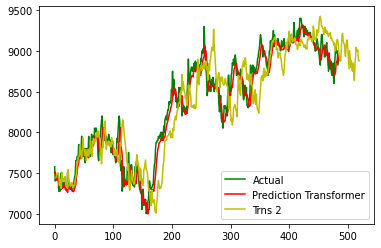

In [43]:
plt.plot(y_val, 'g')
plt.plot(prediction, 'r')
# plt.plot(prediction2, 'b')
plt.plot(forecast['yhat1'], 'y')
plt.legend(['Actual', 'Prediction Transformer', 'Trns 2', 'NP'])

# notes: the neuralprophet prediction is more compared to the actual and transformer as there are inputs of data from the model itself

# Stack/Hybrid

In [44]:
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor

In [45]:
# Combine data prediction result of base models
np_pred = forecast[forecast['ds'].isin(ds_np_val['ds'])].reset_index()
np_pred = np_pred['yhat1']

x_train_meta = np.column_stack((np_pred[n_lags:], prediction[n_lags:]))

In [46]:
print(f"train: {x_train_meta[:10]}")
print(f"label: {y_val[:10]}")

train: [[7441.858  7442.7515]
 [7461.3467 7421.6265]
 [7488.95   7407.9966]
 [7498.96   7429.696 ]
 [7496.9033 7429.4077]
 [7460.741  7399.0903]
 [7350.8877 7346.644 ]
 [7420.865  7375.2026]
 [7325.606  7307.2915]
 [7308.9067 7295.225 ]]
label: [7575. 7400. 7425. 7475. 7475. 7475. 7425. 7275. 7400. 7275.]


In [47]:
# Set meta model
meta_model = LinearRegression()
# meta_model = RandomForestRegressor(n_estimators=2)
print('Linear Regression Train')
meta_model.fit(x_train_meta, y_val[n_lags:])


meta_model2 = Sequential()
meta_model2.add(Dense(8, input_dim=x_train_meta.shape[1], activation='relu'))
meta_model2.add(Dropout(0.1))
meta_model2.add(Dense(16, activation='relu'))
# meta_model2.add(Dropout(0.2))
meta_model2.add(Dense(1, activation='linear'))
print('MLP Train')
meta_model2.compile(optimizer='adam', loss='mse', metrics=['mae', 'mape'])
meta_model2.fit(x_train_meta, y_val[n_lags:], epochs=20, batch_size=32, callbacks=[tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)], verbose=1)

# meta_model3 = LogisticRegression(random_state=0)
# meta_model3.fit(x_train_meta, y_val[n_lags:])

WARNING - (py.warnings._showwarnmsg) - c:\Users\ASUS TUF\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.




Linear Regression Train
MLP Train
Epoch 1/20
 1/16 ━━━━━━━━━━━━━━━━━━━━ 9s 663ms/step - loss: 84925888.0000 - mae: 9183.1084 - mape: 108.1053

WARNING - (py.warnings._showwarnmsg) - c:\Users\ASUS TUF\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\callbacks\early_stopping.py:156: UserWarning:

Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae,mape




16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 867us/step - loss: 79984544.0000 - mae: 8908.2803 - mape: 106.8619
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 69333776.0000 - mae: 8301.6846 - mape: 99.6951  
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 867us/step - loss: 61516688.0000 - mae: 7811.2349 - mape: 93.2059
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 53860904.0000 - mae: 7304.7822 - mape: 87.2853 
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 934us/step - loss: 48198408.0000 - mae: 6899.1890 - mape: 82.3545
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 934us/step - loss: 42950200.0000 - mae: 6489.3569 - mape: 77.5109
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step - loss: 35307432.0000 - mae: 5883.8164 - mape: 70.4092
Epoch 8/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step - loss: 29160674.0000 - mae: 5315.6396 - mape: 63.7742
Epoch 9/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 934us/step - loss: 25516664.0000 - mae: 4909.2085 - mape: 58.6040
Epoch 10/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 867us/

#### Final Prediction

In [48]:
# Use test data to make final prediction
# make prediction with base model
np_y_pred = np_model.predict(ds_np_test)
tf_y_pred = transformer.predict(x_test)

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 499.92it/s]
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


In [49]:
# Combine test data
np_y_pred = np_y_pred[np_y_pred['ds'].isin(ds_np_test['ds'])].reset_index()
np_y_pred = np_y_pred['yhat1']

x_test_meta = np.column_stack((np_y_pred[n_lags:], tf_y_pred[n_lags:]))

In [50]:
# Predict test data with meta model
final_pred = meta_model.predict(x_test_meta)
final_pred2 = meta_model2.predict(x_test_meta)
# final_pred3 = meta_model3.predict(x_test_meta)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


In [51]:
print(range(train_len, len(ds)-n_lags))
print(len(ds))
print(val_len)
print(len(y_test[n_lags:]))

range(607, 1213)
1215
486
120


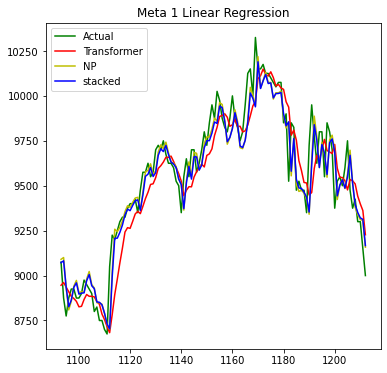

In [52]:
# Plot Prediction
fig = plt.figure(figsize=(6, 6))
plt.plot(range(total_train, len(ds)-n_lags), y_test[n_lags:], 'g-', label="Actual")
plt.plot(range(total_train, len(ds)-n_lags), tf_y_pred[n_lags:], 'r', label="Transformer")
plt.plot(range(total_train, len(ds)-n_lags), np_y_pred[n_lags:], 'y', label='NP')
plt.plot(range(total_train, len(ds)-n_lags), final_pred, 'b', label='stacked')
plt.title('Meta 1 Linear Regression')
plt.legend()

In [53]:
print('Neural Prophet Evaluation')
# print(f"MSE: {mean_squared_error(np_y_pred[n_lags:], y_test[n_lags:])}")
print(f"MAE: {mean_absolute_error(np_y_pred[n_lags:], y_test[n_lags:])}")
print(f"RMSE: {root_mean_squared_error(np_y_pred[n_lags:], y_test[n_lags:])}")
print(f"R2: {r2_score(np_y_pred[n_lags:], y_test[n_lags:])}")

print('Transformer Evaluation')
# print(f"MSE: {mean_squared_error(tf_y_pred[n_lags:], y_test[n_lags:])}")
print(f"MAE: {mean_absolute_error(tf_y_pred[n_lags:], y_test[n_lags:])}")
print(f"RMSE: {root_mean_squared_error(tf_y_pred[n_lags:], y_test[n_lags:])}")
print(f"R2: {r2_score(tf_y_pred[n_lags:], y_test[n_lags:])}")

print('Meta Evaluation')
# print(f"MSE: {mean_squared_error(final_pred, y_test[n_lags:])}")
print(f"MAE: {mean_absolute_error(final_pred, y_test[n_lags:])}")
print(f"RMSE: {root_mean_squared_error(final_pred, y_test[n_lags:])}")
print(f"R2: {r2_score(final_pred, y_test[n_lags:])}")

Neural Prophet Evaluation
MAE: 92.27105305989583
RMSE: 125.5829664789578
R2: 0.8772730103608092
Transformer Evaluation
MAE: 115.30071614583333
RMSE: 152.54017015699242
R2: 0.8428290644031973
Meta Evaluation
MAE: 92.00577799479167
RMSE: 125.52493117901079
R2: 0.875852442616812


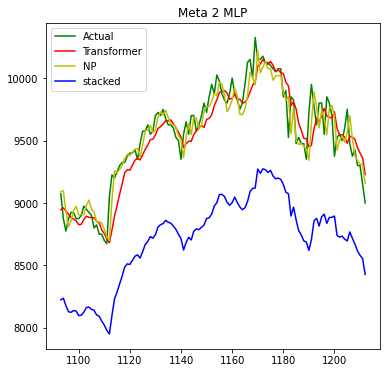

In [54]:
# Plot Predictions
fig = plt.figure(figsize=(6, 6))
plt.plot(range(total_train, len(ds)-n_lags), y_test[n_lags:], 'g-', label="Actual")
plt.plot(range(total_train, len(ds)-n_lags), tf_y_pred[n_lags:], 'r', label="Transformer")
plt.plot(range(total_train, len(ds)-n_lags), np_y_pred[n_lags:], 'y', label='NP')
plt.plot(range(total_train, len(ds)-n_lags), final_pred2, 'b', label='stacked')
plt.title('Meta 2 MLP')
plt.legend()

In [55]:
print('Neural Prophet Evaluation')
# print(f"MSE: {mean_squared_error(np_y_pred[n_lags:], y_test[n_lags:])}")
print(f"MAE: {mean_absolute_error(np_y_pred[n_lags:], y_test[n_lags:])}")
print(f"RMSE: {root_mean_squared_error(np_y_pred[n_lags:], y_test[n_lags:])}")
print(f"R2: {r2_score(np_y_pred[n_lags:], y_test[n_lags:])}")
print('Transformer Evaluation')
# print(f"MSE: {mean_squared_error(tf_y_pred[n_lags:], y_test[n_lags:])}")
print(f"MAE: {mean_absolute_error(tf_y_pred[n_lags:], y_test[n_lags:])}")
print(f"RMSE: {root_mean_squared_error(tf_y_pred[n_lags:], y_test[n_lags:])}")
print(f"R2: {r2_score(tf_y_pred[n_lags:], y_test[n_lags:])}")
print('Meta Evaluation')
# print(f"MSE: {mean_squared_error(final_pred, y_test[n_lags:])}")
print(f"MAE: {mean_absolute_error(final_pred2, y_test[n_lags:])}")
print(f"RMSE: {root_mean_squared_error(final_pred2, y_test[n_lags:])}")
print(f"R2: {r2_score(final_pred2, y_test[n_lags:])}")

Neural Prophet Evaluation
MAE: 92.27105305989583
RMSE: 125.5829664789578
R2: 0.8772730103608092
Transformer Evaluation
MAE: 115.30071614583333
RMSE: 152.54017015699242
R2: 0.8428290644031973
Meta Evaluation
MAE: 840.2172770182292
RMSE: 851.0963333540989
R2: -5.1570180968158255


### Single Models

## Single NP

In [56]:
# Data split with ratio
test_ratio = 0.1

# Calculate size of split based on ratio
test_size = -1 * round(test_ratio * len(ds_np))

# Split the dataset into training, validation, and test sets
ds_np_train2, ds_np_test2 = ds_np[:test_size], ds_np[test_size:]

print(len(ds_np_train2), len(ds_np_test2))

1093 122


Finding best initial lr: 100%|██████████| 227/227 [00:00<00:00, 250.77it/s]


Epoch 110: 100%|██████████| 110/110 [00:00<00:00, 768.03it/s, loss=0.000581, v_num=307, MAE=92.00, RMSE=158.0, Loss=0.000549, RegLoss=0.000]   


,MAE,RMSE,Loss,RegLoss,epoch
0,12693.877930,14823.324219,1.022033,0.0,0
1,7167.927246,8668.823242,0.536460,0.0,1
2,3675.041504,4557.447266,0.232767,0.0,2
3,1865.743042,2301.929932,0.080675,0.0,3
4,1140.212036,1342.543823,0.027261,0.0,4
...,...,...,...,...,...
105,93.003891,161.957520,0.000554,0.0,105
106,91.716118,157.858170,0.000549,0.0,106
107,92.597198,160.005188,0.000552,0.0,107
108,93.241943,161.102264,0.000554,0.0,108


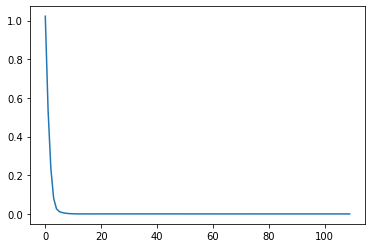

In [57]:
n_lags = 2

single_np_model = NeuralProphet(
    n_changepoints=2,
    n_lags=n_lags,
    drop_missing=True,
)

# Train NP 
metrics = single_np_model.fit(ds_np_train2, progress="plot")
metrics

In [58]:
forecast2 = np_model.predict(ds_np_test2)
forecast2

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 333.25it/s]


,ds,y,yhat1,ar1,trend,season_yearly,season_weekly
0,2023-11-15,9050.000000,NaN,NaN,NaN,NaN,NaN
1,2023-11-16,9075.000000,NaN,NaN,NaN,NaN,NaN
2,2023-11-17,9075.000000,9090.435547,396.117554,8407.501953,444.482452,-157.666901
3,2023-11-20,8875.000000,9100.375977,382.805908,8407.064453,477.345734,-166.839355
4,2023-11-21,8775.000000,8932.280273,193.841141,8406.916992,489.442627,-157.920685
...,...,...,...,...,...,...,...
137,2024-05-24,9341.666667,9392.847656,2217.754883,8379.894531,-1046.392944,-158.408997
138,2024-05-27,9300.000000,9339.655273,2168.420898,8379.456055,-1040.140625,-168.080887
139,2024-05-28,9300.000000,9311.284180,2128.125000,8379.310547,-1036.027222,-160.123672
140,2024-05-29,9150.000000,9307.047852,2111.957764,8379.164062,-1030.955566,-153.118286


In [59]:
np_model.plot_components(forecast2)

ERROR - (NP.plotly.plot_components) - plotly-resampler is not installed. Please install it to use the resampler.


In [60]:
print(f"MAE: {mean_absolute_error(forecast2['y'][n_lags:], forecast2['yhat1'][n_lags:])}")
print(f"RMSE: {root_mean_squared_error(forecast2['y'][n_lags:], forecast2['yhat1'][n_lags:])}")
print(f"R2: {r2_score(forecast2['y'][n_lags:], forecast2['yhat1'][n_lags:])}")

MAE: 85.01558314732142
RMSE: 117.8184275286523
R2: 0.901397696193831


## Single Trans

In [61]:
# Define window size and number of features
window_size = 10
num_features = 1

# make input sequences
X = []
y = []
for i in range(len(ds['Close']) - window_size):
    X.append(ds['Close'][i:i+window_size])
    y.append(ds['Close'][i+window_size])

# lists to arrays
X, y = np.array(X), np.array(y)

x_train2, x_test2 = X[:test_size], X[test_size:]
y_train2, y_test2 = y[:test_size], y[test_size:]

# standarization
scaler_X = StandardScaler()
scaler_y = StandardScaler()

x_train2 = scaler_X.fit_transform(x_train2)
y_train2 = scaler_y.fit_transform(y_train2.reshape(-1, 1)).flatten()

# Use the same transformation on the test data
x_test2 = scaler_X.transform(x_test2)
y_test2 = scaler_y.transform(y_test2.reshape(-1, 1)).flatten()


In [62]:
transformer2 = build_transfromer(head_size=40, num_heads=60, ff_dim=60, num_trans_blocks=4, mlp_units=[256], 
                                mlp_dropout=0.10, dropout=0.10)


transformer2.compile(loss="mse", optimizer=Adam(learning_rate=0.0001), metrics=["mae", 'mape'])

callbacks = [tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]

In [63]:
histT2 = transformer2.fit(x_train2, y_train2, batch_size=32, epochs=50,
                         verbose=1, callbacks=callbacks)

prediction2 = transformer2.predict(x_test2)


Epoch 1/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.9122 - mae: 0.8312 - mape: 98.4295

WARNING - (py.warnings._showwarnmsg) - c:\Users\ASUS TUF\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\callbacks\early_stopping.py:156: UserWarning:

Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae,mape




34/34 ━━━━━━━━━━━━━━━━━━━━ 10s 58ms/step - loss: 0.9076 - mae: 0.8284 - mape: 98.3477
Epoch 2/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - loss: 0.4839 - mae: 0.5653 - mape: 96.5985
Epoch 3/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 0.2063 - mae: 0.3540 - mape: 47.6791
Epoch 4/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - loss: 0.0736 - mae: 0.2014 - mape: 33.9731
Epoch 5/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - loss: 0.0425 - mae: 0.1451 - mape: 32.5321
Epoch 6/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - loss: 0.0415 - mae: 0.1427 - mape: 33.8759
Epoch 7/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - loss: 0.0397 - mae: 0.1408 - mape: 25.9756
Epoch 8/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 0.0382 - mae: 0.1401 - mape: 30.9186
Epoch 9/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - loss: 0.0336 - mae: 0.1340 - mape: 31.8113
Epoch 10/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 0.0372 - mae: 0.1346 - mape: 32.7776
Epoch 11/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/st

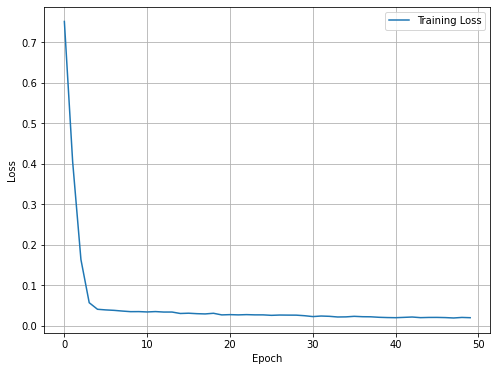

In [64]:
# Graph loss training
plt.figure(figsize=(8, 6))
plt.plot(histT2.history['loss'], label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

In [65]:
prediction2 = prediction2.reshape(-1, 1)
prediction2 = scaler_y.inverse_transform(prediction2)

y_test2 = scaler_y.inverse_transform(y_test2.reshape(-1, 1))

print("TRANSFORMER EVALUATION METRICS")
print(f"MAE: {mean_absolute_error(prediction2, y_test2)}")
print(f"RMSE: {root_mean_squared_error(prediction2, y_test2)}")
print(f"R2: {r2_score(prediction2, y_test2)}")

TRANSFORMER EVALUATION METRICS
MAE: 116.02180455942623
RMSE: 149.28026661915698
R2: 0.8413970412843597


In [66]:
print("Evaluation metrics between models of:")
print("\nProposed Ensemble Np-Trans")
print(f"MAE: {mean_absolute_error(final_pred, y_test[n_lags:])}")
print(f"RMSE: {root_mean_squared_error(final_pred, y_test[n_lags:])}")
print(f"R2: {r2_score(final_pred, y_test[n_lags:])}")

print("\nNeuralProphet")
print(f"MAE: {mean_absolute_error(forecast2['y'][n_lags:], forecast2['yhat1'][n_lags:])}")
print(f"RMSE: {root_mean_squared_error(forecast2['y'][n_lags:], forecast2['yhat1'][n_lags:])}")
print(f"R2: {r2_score(forecast2['y'][n_lags:], forecast2['yhat1'][n_lags:])}")

print("\nTransformer")
print(f"MAE: {mean_absolute_error(prediction2, y_test2)}")
print(f"RMSE: {root_mean_squared_error(prediction2, y_test2)}")
print(f"R2: {r2_score(prediction2, y_test2)}")

Evaluation metrics between models of:

Proposed Ensemble Np-Trans
MAE: 92.00577799479167
RMSE: 125.52493117901079
R2: 0.875852442616812

NeuralProphet
MAE: 85.01558314732142
RMSE: 117.8184275286523
R2: 0.901397696193831

Transformer
MAE: 116.02180455942623
RMSE: 149.28026661915698
R2: 0.8413970412843597


In [67]:
# the result of neuralprohet has some additional data of dates, so we will take only the date that's on the y
forecast2 = forecast2[forecast2['ds'].isin(ds_np_test2['ds'])].reset_index()


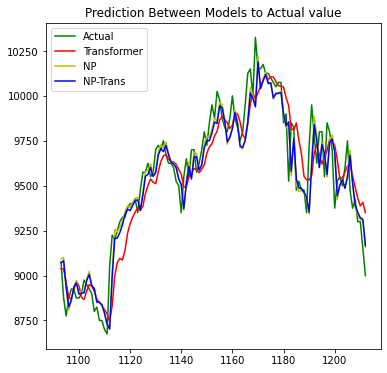

In [68]:
# Plot Prediction

fig = plt.figure(figsize=(6, 6))
plt.plot(range(total_train, len(ds)-n_lags), y_test2[n_lags:], 'g-', label="Actual")
plt.plot(range(total_train, len(ds)-n_lags), prediction2[n_lags:], 'r', label="Transformer")
plt.plot(range(total_train, len(ds)-n_lags), forecast2['yhat1'][n_lags:], 'y', label='NP')
plt.plot(range(total_train, len(ds)-n_lags), final_pred, 'b', label='NP-Trans')
plt.title('Prediction Between Models to Actual value')
plt.legend()

In [69]:
print('Neural Prophet Evaluation')
# print(f"MSE: {mean_squared_error(np_y_pred[n_lags:], y_test[n_lags:])}")
print(f"MAE: {mean_absolute_error(forecast2['yhat1'][n_lags:], y_test[n_lags:])}")
print(f"RMSE: {root_mean_squared_error(forecast2['yhat1'][n_lags:], y_test[n_lags:])}")
print(f"R2: {r2_score(forecast2['yhat1'][n_lags:], y_test[n_lags:])}")

print('Transformer Evaluation')
# print(f"MSE: {mean_squared_error(tf_y_pred[n_lags:], y_test[n_lags:])}")
print(f"MAE: {mean_absolute_error(tf_y_pred[n_lags:], y_test[n_lags:])}")
print(f"RMSE: {root_mean_squared_error(tf_y_pred[n_lags:], y_test[n_lags:])}")
print(f"R2: {r2_score(tf_y_pred[n_lags:], y_test[n_lags:])}")

print('Meta Evaluation')
# print(f"MSE: {mean_squared_error(final_pred, y_test[n_lags:])}")
print(f"MAE: {mean_absolute_error(final_pred, y_test[n_lags:])}")
print(f"RMSE: {root_mean_squared_error(final_pred, y_test[n_lags:])}")
print(f"R2: {r2_score(final_pred, y_test[n_lags:])}")

Neural Prophet Evaluation
MAE: 92.27105305989583
RMSE: 125.5829664789578
R2: 0.8772730103608092
Transformer Evaluation
MAE: 115.30071614583333
RMSE: 152.54017015699242
R2: 0.8428290644031973
Meta Evaluation
MAE: 92.00577799479167
RMSE: 125.52493117901079
R2: 0.875852442616812
